# Solving a First-order Ordinary Differential Equation  (ODE)  

In this notebook, we will solve a first order ODE using sQUlearn's implementations of a Quantum Neural Networks (QNN) differential equation solver, as described in [squlearn.qnn.loss.ODELoss](https://squlearn.github.io/modules/generated/squlearn.qnn.loss.ODELoss.html#squlearn.qnn.loss.ODELoss).


<center>
<img src="images/QNN_ode_workflow.png" alt="pipeline" width="1200"/>

*Fig. 1: General Scheme for solving a differential Equation with a QNN as introduced by Ref. 1*
</center>


Differential Equations are building blocks of many scientific fields. One numerical method to solve these problems consists on representing an ansatz in a suitable basis and solving for the optimal coefficients of the differential equation in this basis. Formally, we consider a differential equations given in its functional form,
\begin{equation}\tag{1}
F = F[\{d^{m}f_{n}/d x^{m}\}_{m,n},\{f_{n}(x)\}_{n},x]=0,
\end{equation}
where $f$ corresponds to the function solution of the differential equations. For example, the differential equation $\frac{df(x)}{dx}=\log(x)$, can be written as $F\left(\frac{df(x)}{dx}, f(x), f\right) = \frac{df(x)}{dx} - \log(x)$. The ansatz $f$ can be represented in a parameterized differentiable form,
\begin{equation}\tag{2}
f=f_{{\theta}},
\end{equation}
and the solution to the differential equation can be seen as an optimization problem, where a loss function, 
\begin{equation}\tag{3}
\mathcal{L}_{{\theta}} = \mathcal{L}_{{\theta}}(\{d^{m}f_{n}/d x^{m}\}_{m,n},\{f_{n}(x)\}_{n},x),
\end{equation}
is optimized to find the ideal parameters ${\theta}_{\mathrm{opt}}$.
\begin{equation}\tag{4}
{\theta}_{\mathrm{opt}}=\arg_{{\theta}}\mathrm{min}(\mathcal{L}_{{\theta}}[d_{x}f,f,x]).
\end{equation}
In our case, the ansatz will be given by a parameterized quantum circuit, known as a Quantum Neural Network (QNN) and we will follow the structure introduced by Ref. [1]. Using an encoding circuit unitary $U_{\phi}(x)$, and a parameterized set of gates $U_{{\theta}}$, a trial state $\ket{f_{{\theta}, \phi}(x)} = U_{{\theta}} U_{\phi}(x) \ket{0}$ is constructed. By measuring this state with regard to an arbitrary cost operator $\hat{C}$, a final trial function is given by,
\begin{equation}\tag{5}
f_{{\theta}, \phi}(x) = \langle \hat{C} \rangle = \bra{f_{{\theta}, \phi}(x)} \hat{C} \ket{f_{{\theta}, \phi}(x)}.
\end{equation}
$\phi$ is a nonlinear function that is used to preprocess the data before encoding it into the quantum state. The encoded state after the first unitary $U_{\phi}(x)$ is then manipulated by the parameterized unitary $U_{{\theta}}$. Note that sQUlearn's flexibility allows us to not only to stick to this quantum circuit design but to use any of the available circuits (or self-designed) in the library. The derivatives of our ansatz functions are calculated under the hood by sQUlearn and the total loss is obtained. The loss is progressively updated by sQUlearn's available optimization algorithms.

Without further ado, we proceed to numerically solve the differential equation.


**References**

1. Kyriienko, O., Paine, A., Elfving, V., "Solving nonlinear differential equations with differentiable quantum circuits", Physical Review A 103 (2021).

### Importing Libraries

In this initial cell, we are importing all the libraries required for the tutorial. We are using sQUlearn to set up the quantum learning problem and `sympy`, to explicitly write the differential equation that we would like to solve


In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from squlearn import Executor
from squlearn.encoding_circuit import KyriienkoEncodingCircuit
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNRegressor, ODELoss
from squlearn.qnn.util import get_lr_decay
from squlearn.optimizers import Adam

e:\dev\squlearn\.venv\Lib\site-packages\pennylane\operation.py:2622: PennyLaneDeprecationWarning: Observable is deprecated and will be removed in v0.43. A generic Operator class should be used instead. If defining an Operator, set the is_hermitian property to True. If checking if an Operator is Hermitian, check the is_hermitian property. 
  warnings.warn(


Our choice of differential equation is the [Bernoulli differential equation](https://en.wikipedia.org/wiki/Bernoulli_differential_equation), whose general form is given by:

\begin{equation}\tag{6}
\frac{dy}{dx} = Q(x)y^n - P(x)y
\end{equation}

This family of differential equations has important applications in many fields. Here, we solve a special case known as the [logistic equation](https://en.wikipedia.org/wiki/Logistic_function). The logistic equation has an analytical solution and its applications include: population growth in ecology, the Fermi-Dirac distribution in physics, and many uses in machine learning. 

For the logistic differential equation, we take $Q(x) =  P(x) = -6$ and $n = 2$ in Eq. $(6)$:

\begin{equation}\tag{7}
\frac{dy}{dx} = -6y^2 + 6y = 6y(1-y)
\end{equation}


First, we need to define the differential equation functional using `sympy`

In [2]:
x, y, dydx = sp.symbols("x y dydx")  # Define the symbols
eq = dydx - 6 * y * (1 - y)  # Define the differential equation

# Define the differential equation, in our notation y depends on the independent variable x
# initial_values corresponds to y(x_0), i.e. the value of y for the first element in the x array
initial_values = [0.5]

Given the differential equation functional, we need to define the squlearn corresponding loss function.
-    To correctly construct the loss function, the sympy variable associated to the independent (`x`), dependent (`y`) and derivatives (`dydx`) must be informed in that order, in this case `symbols_involved_in_ODE=[x, y, dydx]`.
- We used the `boundary_handling="pinned"` which adds a pinning term to the loss function. This is, $\mathcal{L}_{\theta} = \mathcal{L}_{\theta}(dy/dx, y, x) + \eta \left(y(x_0) - u_0 \right)^2$, where $u_0$ corresponds to `initial_values` and $\eta$ is a regularization pinning term. As default $x_0$ corresponds to the first element of the domain array.

In [3]:
loss_ODE = ODELoss(
    eq,
    symbols_involved_in_ODE=[x, y, dydx],
    initial_values=initial_values,
    boundary_handling="pinned",
    eta=10,
)

Now, we proceed to define our quantum solver model. First we define the quantum circuit used as an ansatz

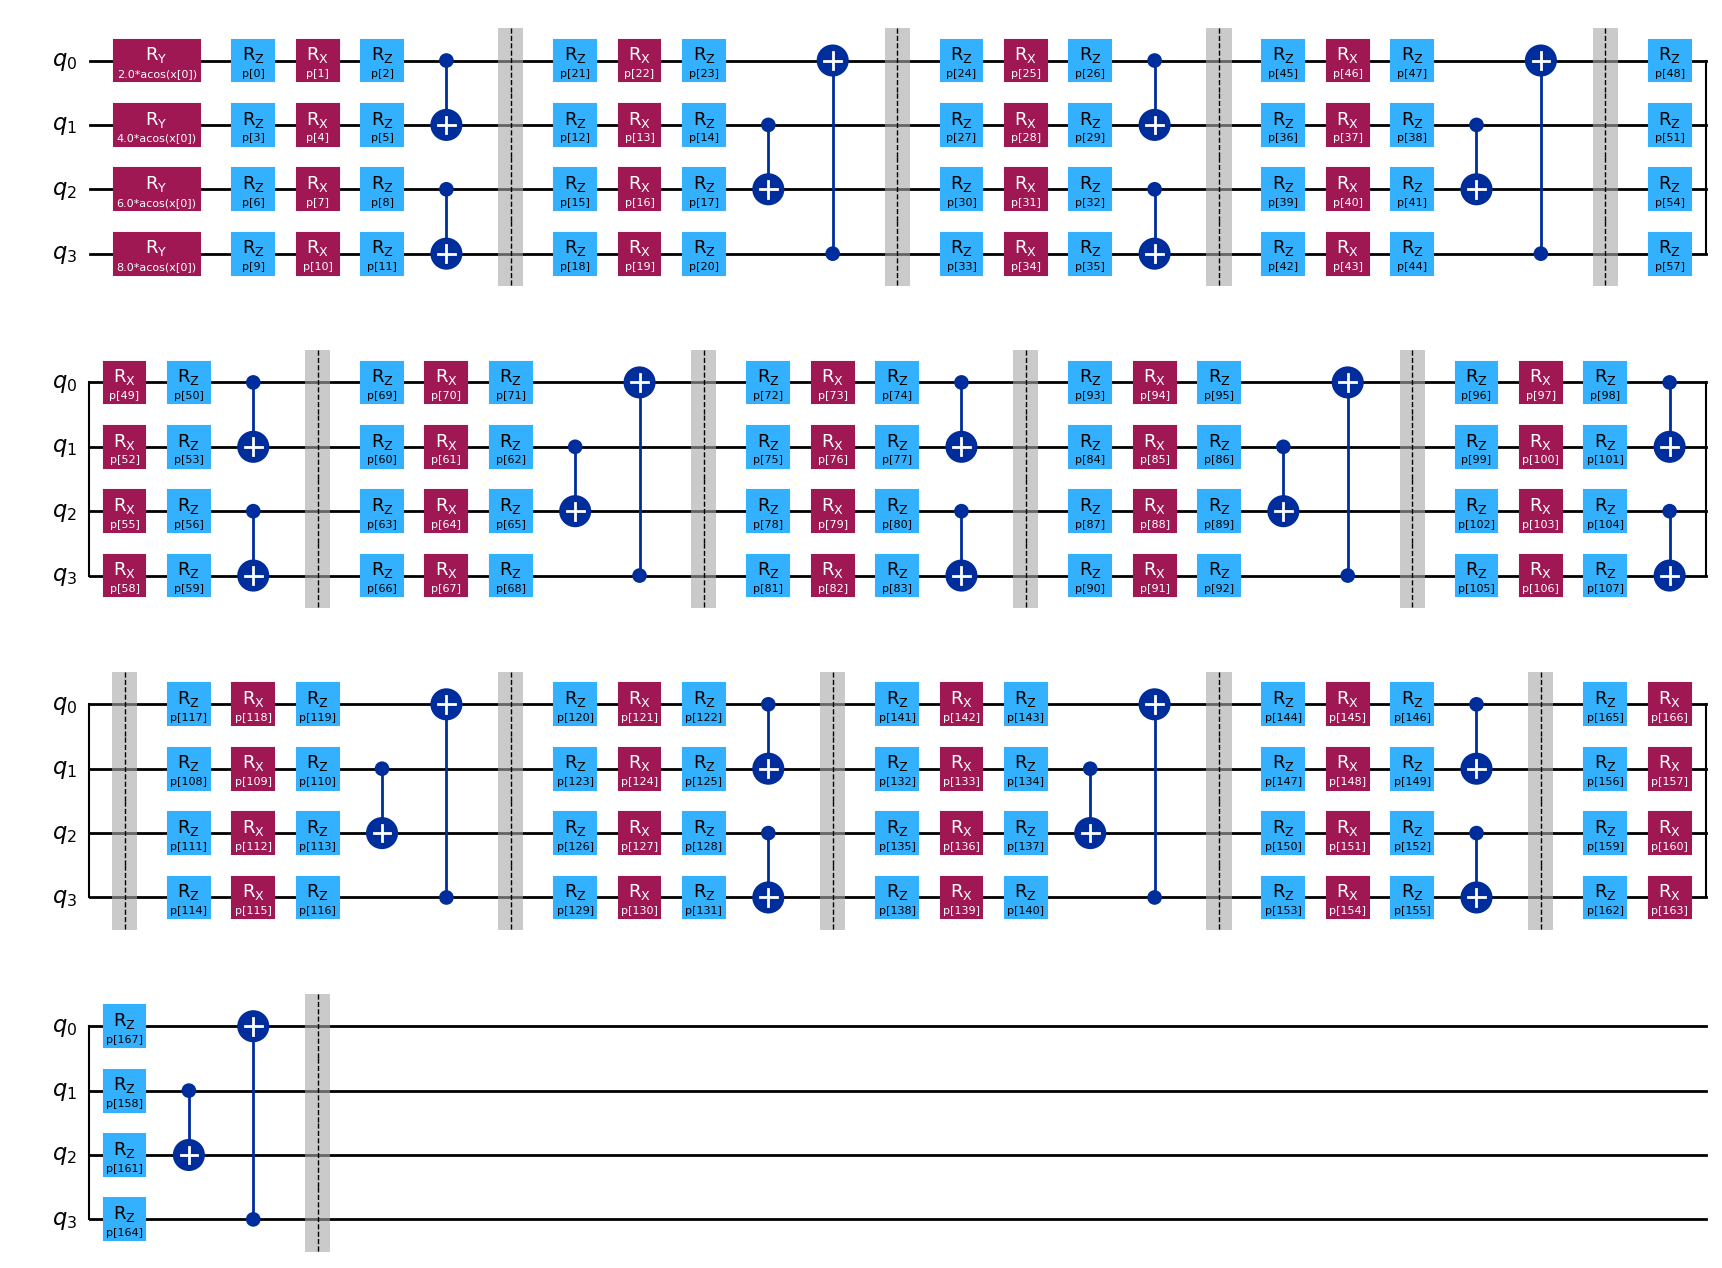

In [4]:
num_qubits = 4
circuit = KyriienkoEncodingCircuit(
    num_qubits=num_qubits,
    encoding_style="chebyshev_tower",  # other options are chebyshev_tower, chebyshev_sparse, chebyshev_product
    variational_arrangement="ABA",  # other option can be HEA (Hardware Efficient Ansatz), with consecutive entangling layers
    num_encoding_layers=1,
    num_variational_layers=14,
)
observable = SummedPaulis(
    num_qubits, op_str=("Z"), include_identity=True
)  # Define the observable ZIII + IZII + IIZI + IIIZ + IIII

param_op_ini = observable.generate_initial_parameters(seed=1)
param_ini = circuit.generate_initial_parameters(seed=1, num_features=1)

circuit.draw(
    "mpl",
    num_features=1,
)

Other parameterized circuits available in sQUlearn can be used interchangeably for this ODE solver interface.

We proceed to define our solver by creating a `QNNRegressor` with the loss function given by `loss_ODE`. In this case, we are using the Adam optimizer with a decaying learning rate.

In [5]:
ode_regressor = QNNRegressor(
    circuit,
    observable,
    Executor("pennylane"),
    loss_ODE,
    Adam(options={"maxiter": 250, "tol": 0.00000009, "lr": get_lr_decay(0.03, 0.01, 250)}),
    param_ini,
    param_op_ini,
    opt_param_op=True,  # if True, the optimizer will also optimize the observable parameters
)

At last, we solve the model by training on a fixed domain (this takes a couple og hours) and compare it to the analytical answer

In [6]:
x_numerical = np.linspace(0, 0.9, 10).reshape(-1, 1)
ref_values = np.zeros(len(x_numerical))
ode_regressor.fit(x_numerical, ref_values)

fit: 100%|██████████| 250/250 [5:52:54<00:00, 84.70s/it]  


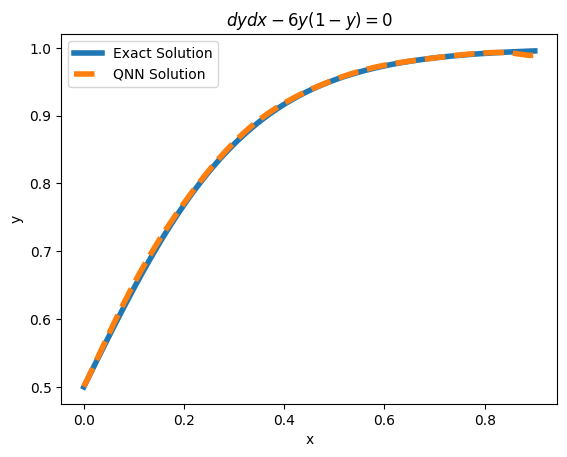

In [7]:
x_numerical = np.linspace(0, 0.9, 100).reshape(-1, 1)

plt.plot(
    x_numerical, (1 / (1 + np.exp(-6 * x_numerical))), "-", label="Exact Solution", linewidth=4
)
plt.plot(x_numerical, ode_regressor.predict(x_numerical), "--", label="QNN Solution", linewidth=4)
plt.title("$dydx - 6y(1-y) = 0$")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()